In [16]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from tqdm.notebook import tqdm
import warnings
warnings. filterwarnings('ignore')
import numpy as np
import pickle

In [2]:
! pip install Sastrawi
! pip install tqdm

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [5]:
df = pd.read_csv(r'D:\SKRIPSI\skripsi_2025\dataset berita terkini 3\politik_merge_compressed.csv.gz', compression='gzip')
df

,Judul,Waktu,Link,Content,source
0,Jokowi Kenakan Pakaian Adat Betawi di Sidang T...,16/08/2024,https://nasional.kompas.com/read/2024/08/16/11...,"JAKARTA, KOMPAS.com - Presiden Joko Widodo me...",kompas
1,Amnesty International Beberkan 6 Indikator Kri...,7/18/2024,https://nasional.tempo.co/read/1893144/amnesty...,"TEMPO.CO, Jakarta - Amnesty International Indo...",tempo
2,"Jelang Long Weekend, Stasiun Kereta Cepat Hali...","Rabu, 08 Mei 2024 19:18 WIB",https://news.detik.com/berita/d-7331666/jelang...,"Stasiun kereta cepat Whoosh di Halim, Jakarta ...",detik
3,KPU Tegaskan Pemilih Tak Terdaftar di DPT Bisa...,13/02/2024,https://nasional.kompas.com/read/2024/02/13/21...,"JAKARTA, KOMPAS.com - Komisi Pemilihan Umum (...",kompas
4,Kemenag Luncurkan Gerakan Senam Haji Jaga Keta...,4/29/2024,https://nasional.tempo.co/read/1861810/kemenag...,"TEMPO.CO, Jakarta - Kementerian Agama atau Kem...",tempo
...,...,...,...,...,...
35864,Kapolri Tegaskan Contraflow di Tol Tetap Dibut...,"Senin, 08 Apr 2024 20:03 WIB",https://news.detik.com/berita/d-7285216/kapolr...,Kapolri Jenderal Listyo Sigit Prabowo menegask...,detik
35865,Temuan Cairan Misterius di Rumah Eks Bupati Je...,"Sabtu, 10 Agu 2024 16:16 WIB",https://news.detik.com/berita/d-7483244/temuan...,Polisi melakukan olah tempat kejadian perkara ...,detik
35866,Danjen Kopassus Bukber dengan Para Mantan Danj...,"Jumat, 05 Apr 2024 20:53 WIB",https://news.detik.com/berita/d-7281174/danjen...,Danjen Kopassus Mayjen TNI Djon Afriandi mengg...,detik
35867,Pertemuan Jokowi dan Paus Fransiskus Akan Baha...,3/9/2024,https://nasional.kompas.com/read/2024/09/03/14...,"TANGERANG, KOMPAS.com - Menteri Agama Yaqut C...",kompas


In [6]:
df = df[['Content', 'Judul']]

In [10]:
df = df.drop_duplicates(subset=['Content'])
df = df.dropna(subset=['Content', 'Judul'])
print(f"Dataset memiliki {len(df)} baris")

Dataset memiliki 35566 baris


In [11]:
sample_df = df.sample(n=1000, random_state=42)
print(f"Sample berhasil diambil dengan {len(sample_df)} baris")

Sample berhasil diambil dengan 1000 baris


PREPROCESSING DATA

In [14]:
#Cleaning Data

def clean_berita(text):
    # Penanganan nilai null
    if not isinstance(text, str):
        text = str(text)

    text = text.replace('â€œ', '').replace('â€', '')
    text = re.sub(r'^[A-Z]+, [A-Za-z0-9\.]+(\.com)? - ', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9.,;:!?\'" ]', ' ', text)

    # Normalisasi whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [15]:
# Normalisasi
#Normalisasi
norm_berita = {
    # Singkatan media dan lokasi
    " kompas.com ": " ",
    " tempo.co ": " ",
    " detikcom ": " ",

    # Singkatan waktu dan ukuran
    " wib ": " waktu indonesia barat ",
    " km ": " kilometer ",
    " m ": " meter ",

    # Singkatan jabatan dan institusi
    " presiden ": " presiden ",
    " ri ": " republik indonesia ",
    " dpr ": " dewan perwakilan rakyat ",
    " dpd ": " dewan perwakilan daerah ",
    " mpr ": " majelis permusyawaratan rakyat ",
    " pemilu ": " pemilihan umum ",
    " kpu ": " komisi pemilihan umum ",
    " ksp ": " kantor staf presidenan ",
    " ikn ": " ibu kota nusantara ",
    " tni ": " tentara nasional indonesia ",
    " polri ": " kepolisian republik indonesia ",
    " kpk ": " komisi pemberantasan korupsi ",
    " pdip ": " partai demokrasi indonesia perjuangan ",
    " lsi ": " lembaga survei indonesia ",
    " jppr ": " jaringan pendidikan pemilih untuk rakyat ",
    " uu ": " undang-undang ",
    " ruu ": " rancangan undang-undang ",
    " ham ": " hak asasi manusia ",
    " ite ": " informasi dan transaksi elektronik ",

    # Nama-nama yang sering muncul
    " jokowi ": " joko widodo ",
    " puan maharani ": " puan maharani ",
    " megawati soekarnoputri ": " megawati soekarnoputri ",
    " prabowo ": " prabowo ",

    # Singkatan umum dalam berita
    " yg ": " yang ",
    " dg ": " dengan ",
    " dlm ": " dalam ",
    " tsb ": " tersebut ",
    " tgl ": " tanggal ",
    " jk ": " jika ",
    " pd ": " pada ",
    " dr ": " dari ",
    " utk ": " untuk ",
    " spy ": " supaya ",
    " thn ": " tahun ",
    " sbb ": " sebagai berikut ",
    " jt ": " juta ",
    " tdk ": " tidak ",
    " sdh ": " sudah ",
    " blm ": " belum ",
    " hrs ": " harus ",
    " jl ": " jalan ",
    " no ": " nomor ",
    " bpk ": " bapak ",
    " sdr ": " saudara ",

    # Kata serapan yang sering salah tulis dan simbol
    " tehnologi ": " teknologi ",
    " aktifitas ": " aktivitas ",
    " sistim ": " sistem ",
    " intruksi ": " instruksi ",
    " trima ": " terima ",
    " whoosh ": " whoosh ",
    " -Â ": " - ",
    " Â ": " ",

    # Kata-kata informal
    " gak ": " tidak ",
    " nggak ": " tidak ",
    " enggak ": " tidak ",
    " udah ": " sudah ",
    " aja ": " saja ",
    " doang ": " saja ",
    " gede ": " besar ",
    " banget ": " sangat ",
}

def normalisasi_berita(text):
    # Memastikan input adalah string
    if not isinstance(text, str):
        text = str(text)

    # Tambahkan spasi di awal dan akhir untuk memudahkan penggantian
    text = " " + text + " "

    # Lakukan penggantian berdasarkan kamus normalisasi
    for key, value in norm_berita.items():
        text = text.replace(key, value)

    # Hapus spasi berlebih dan kembalikan
    return re.sub(r'\s+', ' ', text).strip()

In [16]:
# Case Folding
def case_folding_berita(text):
    if not isinstance(text, str):
        text = str(text)
    return text.lower()

In [17]:
# Tokenizing
def tokenizing(text):
    return word_tokenize(text)

In [21]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stopwords gabungan dari NLTK dan kustom
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {
    'ya', 'nya', 'juga', 'ini', 'itu', 'dan', 'di', 'ke', 'dengan',
    'untuk', 'pada', 'ada', 'yang', 'dari', 'oleh', 'tersebut',
    'bisa', 'dapat', 'seperti', 'karena', 'saat'
}
stop_words.update(custom_stopwords)

In [22]:
def process_all_steps(text):
    # Penanganan null
    if not isinstance(text, str):
        text = str(text)
        
    # Cleaning
    text = clean_berita(text)
    
    # Normalisasi
    text = normalisasi_berita(text)
    
    # Case folding
    text = case_folding_berita(text)
    
    # Tokenizing
    tokens = word_tokenize(text)
    
    # Filtering stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Join kembali menjadi teks
    return ' '.join(stemmed_tokens)

In [23]:
print("\nMemproses kolom Content...")
tqdm.pandas(desc="Processing Content")
sample_df['processed_content'] = sample_df['Content'].progress_apply(process_all_steps)

print("\nMemproses kolom Judul...")
tqdm.pandas(desc="Processing Judul")
sample_df['processed_judul'] = sample_df['Judul'].progress_apply(process_all_steps)


Memproses kolom Content...


Processing Content:   0%|          | 0/1000 [00:00<?, ?it/s]


Memproses kolom Judul...


Processing Judul:   0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
output_file = 'processed_sample_1000.csv'
sample_df.to_csv(output_file, index=False)
print(f"\nProses selesai! Hasil disimpan ke {output_file}")


Proses selesai! Hasil disimpan ke processed_sample_1000.csv


In [29]:
from IPython.display import display
display(sample_df[['Content', 'processed_content', 'Judul', 'processed_judul']].head())

,Content,processed_content,Judul,processed_judul
11082,"TEMPO.CO, Jakarta - Sejak 26 tahun yang lalu, ...",tempo co jakarta 26 mei kenang lahir reforma...,Bara Reformasi Terus Dihidupkan: Aksi Kamisan ...,bara reformasi hidup aksi kamis adil korban culi
21104,"TEMPO.CO, Jakarta - Menteri Koordinator Pereko...",tempo co jakarta menteri koordinator ekonomi ...,Airlangga soal Ratas Prabowo dengan Jokowi: Ba...,airlangga ratas prabowo jokowi bahas perintah
32932,"TEMPO.CO, Yogyakarta - Capres nomor urut 03 Ga...",tempo co yogyakarta capres nomor urut 03 ganj...,"Prabowo-Gibran Gencar Gerak di Jateng, Ganjar ...",prabowo gibran gencar gerak jateng ganjar kan...
21779,KOMPAS.com – Partai Keadilan Sejahtera (PKS) ...,kompas com partai adil sejahtera pks buka opsi...,Soal Sinyal PKS Tinggalkan Anies dan Gabung KI...,sinyal pks tinggal anies gabung kim plus zulh...
32515,Dalam sejarahnya selama menjadi Inspektur Upac...,sejarah inspektur upacara hut merdeka ri pres...,Daftar Baju Adat yang Pernah Dipakai Jokowi sa...,daftar baju adat pakai jokowi upacara 17 agustus


LABELING

In [11]:
def label_sentimen_ekonomi(processed_text):
    # Definisikan kategori sentimen untuk konteks ekonomi/nilai tukar
    sentiment_categories = {
        'penguatan_rupiah': [
            'menguat', 'naik', 'apresiasi', 'positif', 'surplus', 'berkembang',
            'tumbuh', 'stabil', 'kokoh', 'fundamental', 'kepercayaan', 'investasi'
        ],
        'pelemahan_rupiah': [
            'melemah', 'turun', 'depresiasi', 'negatif', 'defisit', 'penurunan', 
            'krisis', 'resesi', 'inflasi', 'tekanan', 'ketidakpastian', 'volatil'
        ],
        # Faktor-faktor ekonomi dari proposal
        'faktor_penguatan': [
            'ekspor', 'cadangan', 'devisa', 'investasi', 'pertumbuhan', 'ekonomi',
            'kebijakan', 'moneter', 'stabilitas', 'politik', 'kepercayaan', 'investor'
        ],
        'faktor_pelemahan': [
            'inflasi', 'impor', 'utang', 'defisit', 'anggaran', 'ketidakpastian',
            'politik', 'global', 'minyak', 'krisis', 'konflik', 'perang'
        ]
    }
    
    # Pisahkan kata-kata teks
    words = processed_text.split()
    
    # Hitung skor untuk setiap kategori
    scores = {category: 0 for category in sentiment_categories}
    
    for word in words:
        for category, category_words in sentiment_categories.items():
            if word in category_words:
                scores[category] += 1
    
    # Tentukan sentimen berdasarkan skor kategori
    penguatan_score = scores['penguatan_rupiah'] + scores['faktor_penguatan']
    pelemahan_score = scores['pelemahan_rupiah'] + scores['faktor_pelemahan']
    
    # Klasifikasi biner (hanya positif atau negatif)
    if penguatan_score >= pelemahan_score:
        return 'positif'  # Berita berpotensi memperkuat rupiah
    else:
        return 'negatif'  # Berita berpotensi melemahkan rupiah

In [12]:
def label_sentimen_lexicon(processed_text):
    # Definisikan kamus kata positif dan negatif
    positive_words = [
        'tumbuh', 'naik', 'positif', 'apresiasi', 'kuat', 'untung', 'stabil',
        'baik', 'optimis', 'tingkat', 'sukses', 'unggul', 'dorong', 'dukung',
        'laju', 'surplus', 'kokoh', 'angkat', 'dongkrak', 'pemulih', 'tekan',
        'perkuat', 'rekor', 'prestasi', 'potensial', 'prospek', 'efisien'
    ]
    
    negative_words = [
        'turun', 'lemah', 'negatif', 'rugi', 'krisis', 'defisit', 'buruk',
        'tekanan', 'resesi', 'inflasi', 'rendah', 'lambat', 'kendala', 'akibat',
        'masalah', 'sulit', 'khawatir', 'menurun', 'jatuh', 'tekor', 'tertekan',
        'beban', 'tergerus', 'risiko', 'ancam', 'hambat', 'kesulitan', 'terhambat'
    ]
    
    # Hitung jumlah kata positif dan negatif dalam teks
    words = processed_text.split()
    
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)
    
    # Klasifikasi biner (hanya positif atau negatif)
    if positive_count >= negative_count:
        return 'positif'
    else:
        return 'negatif'

In [13]:
def combine_methods_binary(sample_df):
    # Terapkan kedua metode pelabelan pada konten berita
    sample_df['label_lexicon'] = sample_df['processed_content'].apply(label_sentimen_lexicon)
    sample_df['label_ekonomi'] = sample_df['processed_content'].apply(label_sentimen_ekonomi)
    
    # Gabungkan hasil dengan voting sederhana
    def vote_labels(row):
        labels = [row['label_lexicon'], row['label_ekonomi']]
        
        if labels.count('positif') > labels.count('negatif'):
            return 'positif'
        elif labels.count('negatif') > labels.count('positif'):
            return 'negatif'
        else:
            # Jika terjadi keseimbangan, berikan prioritas pada metode ekonomi
            # karena lebih sesuai dengan konteks penelitian Anda
            return row['label_ekonomi']
    
    sample_df['final_label'] = sample_df.apply(vote_labels, axis=1)
    return sample_df

In [14]:
sample_df = pd.read_csv('processed_sample_1000.csv')
labeled_df = combine_methods_binary(sample_df)
print("Distribusi label sentimen:")
print(labeled_df['final_label'].value_counts())
labeled_df.to_csv('labeled_dataset.csv', index=False)

Distribusi label sentimen:
positif    859
negatif    141
Name: final_label, dtype: int64


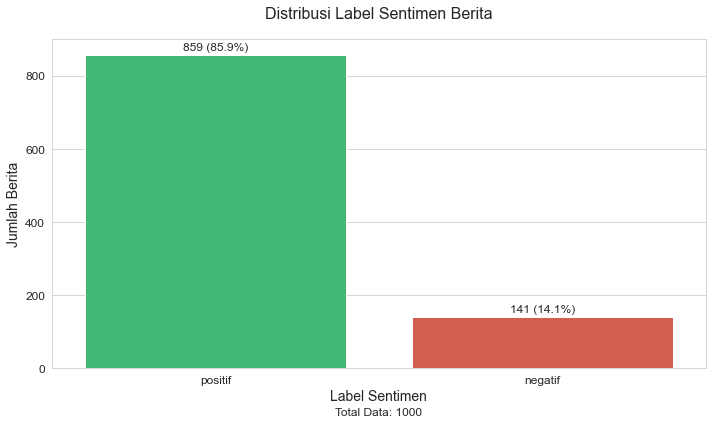

Distribusi Label Sentimen:
positif: 859 berita (85.90%)
negatif: 141 berita (14.10%)


In [26]:
labeled_df = pd.read_csv('labeled_dataset.csv')

# Hitung jumlah data untuk setiap label
label_counts = labeled_df['final_label'].value_counts()

# Siapkan visualisasi
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# Buat bar chart
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#2ecc71', '#e74c3c'])
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 5, f'{count} ({count/len(labeled_df)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=12)
plt.title('Distribusi Label Sentimen Berita', fontsize=16, pad=20)
plt.xlabel('Label Sentimen', fontsize=14)
plt.ylabel('Jumlah Berita', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(0.5, -0.15, f'Total Data: {len(labeled_df)}', ha='center', va='bottom', fontsize=12, transform=ax.transAxes)
plt.tight_layout()
plt.show()
print("Distribusi Label Sentimen:")
for label, count in label_counts.items():
    percentage = count / len(labeled_df) * 100
    print(f"{label}: {count} berita ({percentage:.2f}%)")

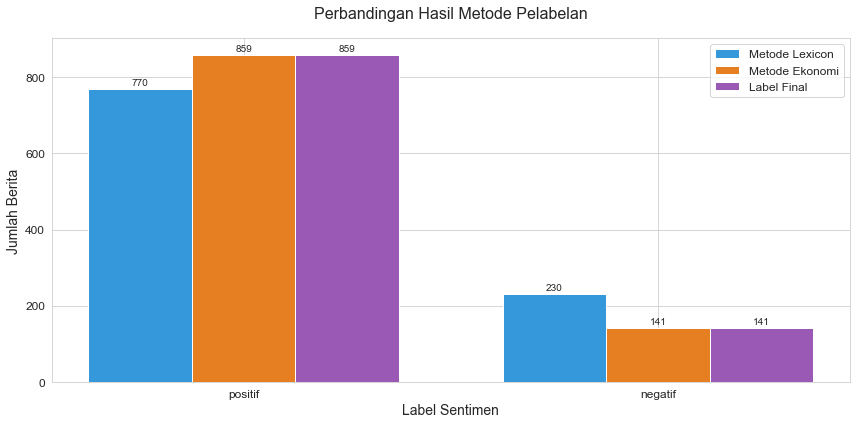

In [24]:
# Visualisasi perbandingan hasil dari dua metode pelabelan
plt.figure(figsize=(12, 6))

# Hitung jumlah data untuk setiap label dari kedua metode
label_lexicon_counts = labeled_df['label_lexicon'].value_counts()
label_ekonomi_counts = labeled_df['label_ekonomi'].value_counts()
final_label_counts = labeled_df['final_label'].value_counts()

# Siapkan data untuk plot
labels = ['positif', 'negatif']
lexicon_values = [label_lexicon_counts.get('positif', 0), label_lexicon_counts.get('negatif', 0)]
ekonomi_values = [label_ekonomi_counts.get('positif', 0), label_ekonomi_counts.get('negatif', 0)]
final_values = [final_label_counts.get('positif', 0), final_label_counts.get('negatif', 0)]

# Posisi bar
x = np.arange(len(labels))
width = 0.25

# Buat grouped bar chart
plt.bar(x - width, lexicon_values, width, label='Metode Lexicon', color='#3498db')
plt.bar(x, ekonomi_values, width, label='Metode Ekonomi', color='#e67e22')
plt.bar(x + width, final_values, width, label='Label Final', color='#9b59b6')

# Tambahkan angka di atas setiap bar
for i, count in enumerate(lexicon_values):
    plt.text(i - width, count + 5, f'{count}', ha='center', va='bottom', fontsize=10)
for i, count in enumerate(ekonomi_values):
    plt.text(i, count + 5, f'{count}', ha='center', va='bottom', fontsize=10)
for i, count in enumerate(final_values):
    plt.text(i + width, count + 5, f'{count}', ha='center', va='bottom', fontsize=10)

plt.title('Perbandingan Hasil Metode Pelabelan', fontsize=16, pad=20)
plt.xlabel('Label Sentimen', fontsize=14)
plt.ylabel('Jumlah Berita', fontsize=14)
plt.xticks(x, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

PERHITUNGAN TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz, load_npz
labeled_df = pd.read_csv('labeled_dataset.csv')

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,           # Abaikan kata yang muncul di kurang dari 2 dokumen
    max_df=0.95,        # Abaikan kata yang muncul di lebih dari 95% dokumen
    sublinear_tf=True,  # Gunakan 1+log(tf) bukan tf mentah
    use_idf=True,       # Terapkan IDF weighting
    norm='l2'           # Normalisasi vektor ke panjang unit (ukuran L2)
)

# Fit dan transform data menggunakan kolom processed_content
tfidf_matrix = tfidf_vectorizer.fit_transform(labeled_df['processed_content'])

# Simpan matriks TF-IDF dan vectorizer untuk digunakan pada data testing nanti
save_npz('tfidf_matrix.npz', tfidf_matrix)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Dapatkan nama fitur (kata-kata) - menggunakan get_feature_names() untuk versi scikit-learn lama
feature_names = tfidf_vectorizer.get_feature_names()
print(f"Dimensi matriks TF-IDF: {tfidf_matrix.shape}")
print(f"Jumlah fitur (kata): {len(feature_names)}")

# Contoh menampilkan beberapa kata dengan nilai TF-IDF tertinggi untuk beberapa dokumen
def show_top_tfidf_terms(tfidf_matrix, feature_names, doc_idx, top_n=10):
    row = tfidf_matrix[doc_idx].toarray()[0]
    
    # Urutkan nilai TF-IDF dan ambil top_n tertinggi
    top_indices = row.argsort()[-top_n:][::-1]
    top_terms = [(feature_names[i], row[i]) for i in top_indices]
    
    return top_terms

# Tampilkan top terms untuk 5 dokumen pertama
for i in range(5):
    print(f"\nDokumen #{i+1} (Label: {labeled_df.iloc[i]['final_label']})")
    print(f"Isi: {labeled_df.iloc[i]['processed_content'][:70]}...")
    top_terms = show_top_tfidf_terms(tfidf_matrix, feature_names, i)
    for term, score in top_terms:
        print(f"  {term}: {score:.4f}")

Dimensi matriks TF-IDF: (1000, 6821)
Jumlah fitur (kata): 6821

Dokumen #1 (Label: positif)
Isi: tempo co  jakarta 26  mei kenang lahir reformasi indonesia patut raya ...
  1997: 0.2239
  1998: 0.2199
  aktivis: 0.1720
  paksa: 0.1694
  ham: 0.1574
  aksi: 0.1428
  kontras: 0.1423
  semanggi: 0.1382
  mei: 0.1283
  2007: 0.1266

Dokumen #2 (Label: positif)
Isi: tempo co  jakarta menteri koordinator ekonomi airlangga hartarto  konf...
  unggah: 0.2135
  ratas: 0.2003
  airlangga: 0.1919
  venue: 0.1621
  pon: 0.1550
  layar: 0.1550
  april: 0.1548
  kanan: 0.1493
  prabowo: 0.1425
  momen: 0.1256

Dokumen #3 (Label: positif)
Isi: tempo co  yogyakarta capres nomor urut 03 ganjar pranowo masalah pasan...
  ganjar: 0.2077
  eksekutif: 0.1953
  gencar: 0.1873
  jateng: 0.1787
  banteng: 0.1684
  gerak: 0.1643
  pilar: 0.1535
  kampanye: 0.1524
  suara: 0.1253
  rawan: 0.1234

Dokumen #4 (Label: positif)
Isi: kompas com partai adil sejahtera pks buka opsi pisah jalan anies baswe...
  zainudi

In [29]:
X = tfidf_matrix
y = labeled_df['final_label'].values

# Simpan label sentimen untuk digunakan nanti
np.save('sentiment_labels.npy', y)

print(f"Jumlah data: {X.shape[0]}")
print(f"Distribusi label: {pd.Series(y).value_counts().to_dict()}")

Jumlah data: 1000
Distribusi label: {'positif': 859, 'negatif': 141}


NAIVE BAYES CLASSIFIER

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import load_npz

# Load data yang sudah disimpan sebelumnya
tfidf_matrix = load_npz('tfidf_matrix.npz')
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Load labeled dataset untuk mendapatkan label sentimen
labeled_df = pd.read_csv('labeled_dataset.csv')
y = labeled_df['final_label'].map({'positif': 1, 'negatif': 0}).values

In [31]:
# Bagi data menjadi training dan testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Inisialisasi dan latih model Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Prediksi pada data testing
y_pred = nb_classifier.predict(X_test)

Akurasi: 0.8600

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        28
     positif       0.86      1.00      0.92       172

    accuracy                           0.86       200
   macro avg       0.43      0.50      0.46       200
weighted avg       0.74      0.86      0.80       200



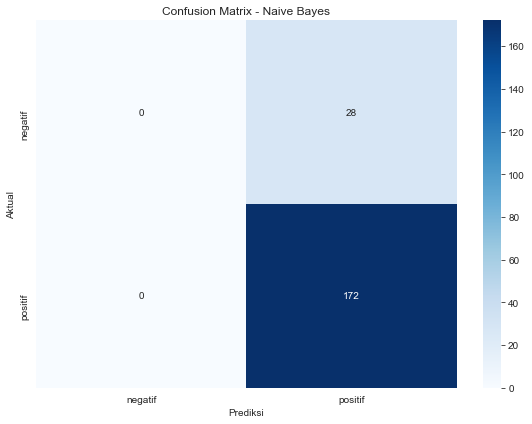

In [39]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['negatif', 'positif'])

# Tampilkan hasil evaluasi
print(f"Akurasi: {accuracy:.4f}")
print("\nLaporan Klasifikasi:")
print(class_report)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif', 'positif'],
            yticklabels=['negatif', 'positif'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Naive Bayes')
plt.tight_layout()
plt.show()

In [35]:
# Analisis kata-kata dengan bobot tertinggi untuk setiap kelas
def analyze_important_features(vectorizer, clf, class_labels, n=20):
    """Tampilkan n kata dengan bobot tertinggi untuk setiap kelas"""
    feature_names = vectorizer.get_feature_names()
    
    for i, class_label in enumerate(class_labels):
        # Ambil koefisien dari kelas ini (log-probabilitas)
        top_features = clf.feature_log_prob_[i]
        
        # Urutkan indeks fitur berdasarkan bobot (probabilitas)
        top_indices = top_features.argsort()[-n:][::-1]
        
        # Tampilkan kata dan bobotnya
        print(f"\nTop {n} kata untuk kelas '{class_label}':")
        for idx in top_indices:
            print(f"{feature_names[idx]}: {np.exp(top_features[idx]):.6f}")  # Convert log-prob ke prob
            
# Analisis kata-kata penting untuk sentimen positif dan negatif            
analyze_important_features(tfidf_vectorizer, nb_classifier, class_labels=['negatif', 'positif'])


Top 20 kata untuk kelas 'negatif':
turun: 0.000719
presiden: 0.000482
negara: 0.000456
indonesia: 0.000449
menteri: 0.000445
jakarta: 0.000436
perintah: 0.000426
jalan: 0.000425
jokowi: 0.000416
milik: 0.000404
orang: 0.000399
ri: 0.000389
pilih: 0.000380
partai: 0.000376
bantu: 0.000375
politik: 0.000371
video: 0.000365
prabowo: 0.000363
atur: 0.000358
wilayah: 0.000356

Top 20 kata untuk kelas 'positif':
jakarta: 0.001676
partai: 0.001566
presiden: 0.001381
ketua: 0.001238
pilih: 0.001216
indonesia: 0.001193
jokowi: 0.001180
calon: 0.001134
prabowo: 0.001090
perintah: 0.001065
menteri: 0.001042
wakil: 0.000999
pilkada: 0.000994
politik: 0.000947
jalan: 0.000941
negara: 0.000933
anies: 0.000923
putus: 0.000920
temu: 0.000918
kota: 0.000906


model ini memiliki akurasi yang cukup tinggi (86%), tetapi tidak mampu memprediksi kelas negatif sama sekali. Model hanya memprediksi kelas positif untuk semua data, seperti yang ditunjukkan oleh recall 1.00 untuk kelas positif dan 0.00 untuk kelas negatif. Model ini tidak akurat mengidentifikasi sentimen negatif, dan akurasi yang tinggi hanya karena ketidakseimbangan distribusi kelas (172 positif vs 28 negatif).